In [1]:
# AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 32
learning_rate = 0.001
num_epochs = 20




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix
import torchaudio



from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


In [3]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [4]:

# Define a function to load the waveform and the sample rate from a file
# def load_waveform(file_path):
#     waveform, sample_rate = torchaudio.load(file_path)
#     return waveform, sample_rate

path_to_train = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/"
path_to_test = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/test/"

train_dataset = AudioProcessor(audio_dir=path_to_train)
val_dataset = AudioProcessor(audio_dir=path_to_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)







# # Create an instance of AudioProcessor
# audio_processor = AudioProcessor(AUDIO_DIR)
#
# # Create the dataset using the audio_processor instance
# dataset = audio_processor


# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#
# # Create DataLoader
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Music waves: ['/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_4_stretch.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_12_noise.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_13_stretch.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_4_reverse.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/glass1.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_45_pitch.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_33_noise.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_7_noise.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_49_noise.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/augmented_21_stretch.wav', '/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/music_wav/classi

In [5]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

In [6]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.78it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1831 | Train Accuracy: 32.38%
Validation Loss: 1.1494 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 2/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.17it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1448 | Train Accuracy: 31.90%
Validation Loss: 1.1672 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 3/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.02it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1292 | Train Accuracy: 33.93%
Validation Loss: 1.1233 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 4/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.54it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1261 | Train Accuracy: 32.14%
Validation Loss: 1.1692 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 5/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.63it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1160 | Train Accuracy: 31.66%
Validation Loss: 1.1498 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 6/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.49it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1139 | Train Accuracy: 33.21%
Validation Loss: 1.0690 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 7/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.47it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1124 | Train Accuracy: 33.93%
Validation Loss: 1.1355 | Validation Accuracy: 43.59%
Validation Precision: 0.3374
Validation Recall: 0.4359
Validation F1-score: 0.3405
Validation MCC: 0.2200
Epoch: 8/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.14it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1101 | Train Accuracy: 32.26%
Validation Loss: 1.1293 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 9/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.12it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1069 | Train Accuracy: 32.86%
Validation Loss: 1.1341 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 10/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.26it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1073 | Train Accuracy: 32.97%
Validation Loss: 1.0653 | Validation Accuracy: 33.33%
Validation Precision: 0.1111
Validation Recall: 0.3333
Validation F1-score: 0.1667
Validation MCC: 0.0000
Epoch: 11/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.34it/s]
/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.0794 | Train Accuracy: 36.80%
Validation Loss: 0.9918 | Validation Accuracy: 51.28%
Validation Precision: 0.3444
Validation Recall: 0.5128
Validation F1-score: 0.4067
Validation MCC: 0.3195
Epoch: 12/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.23it/s]


Train Loss: 1.0491 | Train Accuracy: 46.48%
Validation Loss: 0.9394 | Validation Accuracy: 61.54%
Validation Precision: 0.6154
Validation Recall: 0.6154
Validation F1-score: 0.5427
Validation MCC: 0.4849
Epoch: 13/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.35it/s]


Train Loss: 1.0279 | Train Accuracy: 48.51%
Validation Loss: 0.9215 | Validation Accuracy: 48.72%
Validation Precision: 0.5476
Validation Recall: 0.4872
Validation F1-score: 0.4782
Validation MCC: 0.2449
Epoch: 14/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.22it/s]


Train Loss: 0.9895 | Train Accuracy: 54.72%
Validation Loss: 1.0195 | Validation Accuracy: 53.85%
Validation Precision: 0.5611
Validation Recall: 0.5385
Validation F1-score: 0.5073
Validation MCC: 0.3326
Epoch: 15/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.08it/s]


Train Loss: 0.9201 | Train Accuracy: 56.39%
Validation Loss: 1.0623 | Validation Accuracy: 56.41%
Validation Precision: 0.5516
Validation Recall: 0.5641
Validation F1-score: 0.5515
Validation MCC: 0.3507
Epoch: 16/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.46it/s]


Train Loss: 0.8816 | Train Accuracy: 56.99%
Validation Loss: 1.1159 | Validation Accuracy: 51.28%
Validation Precision: 0.5784
Validation Recall: 0.5128
Validation F1-score: 0.5176
Validation MCC: 0.2877
Epoch: 17/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.55it/s]


Train Loss: 0.8211 | Train Accuracy: 61.41%
Validation Loss: 1.2611 | Validation Accuracy: 48.72%
Validation Precision: 0.5306
Validation Recall: 0.4872
Validation F1-score: 0.4435
Validation MCC: 0.2512
Epoch: 18/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.70it/s]


Train Loss: 0.7647 | Train Accuracy: 62.01%
Validation Loss: 1.0490 | Validation Accuracy: 58.97%
Validation Precision: 0.5595
Validation Recall: 0.5897
Validation F1-score: 0.5598
Validation MCC: 0.3953
Epoch: 19/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.47it/s]


Train Loss: 0.7187 | Train Accuracy: 66.43%
Validation Loss: 1.2018 | Validation Accuracy: 51.28%
Validation Precision: 0.5072
Validation Recall: 0.5128
Validation F1-score: 0.5028
Validation MCC: 0.2728
Epoch: 20/20


Training:   0%|                                                              | 0/27 [00:00<?, ?it/s]/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|█████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.25it/s]


Train Loss: 0.6845 | Train Accuracy: 67.62%
Validation Loss: 1.2348 | Validation Accuracy: 58.97%
Validation Precision: 0.5683
Validation Recall: 0.5897
Validation F1-score: 0.5754
Validation MCC: 0.3873
Training finished.


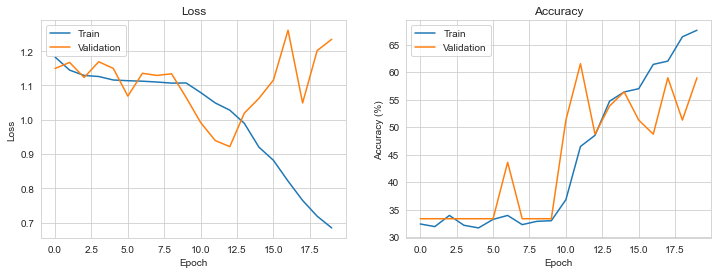

In [7]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

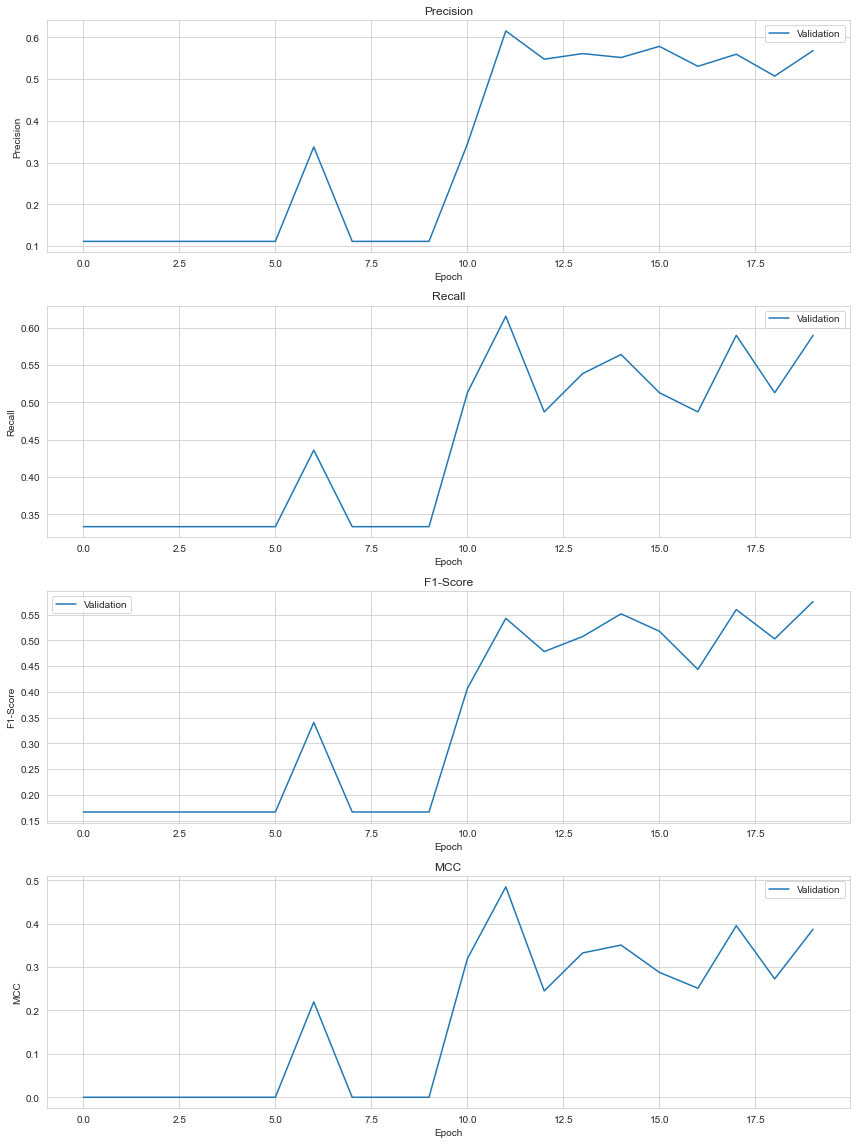

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Precision
ax1.plot(val_precisions, label='Validation')
ax1.set_title('Precision')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall
ax2.plot(val_recalls, label='Validation')
ax2.set_title('Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall')
ax2.legend()

# F1-score
ax3.plot(val_f1_scores, label='Validation')
ax3.set_title('F1-Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()

# MCC
ax4.plot(val_mccs, label='Validation')
ax4.set_title('MCC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MCC')
ax4.legend()

plt.tight_layout()
plt.show()


/Users/zainhazzouri/miniforge3/envs/Bachelor_Thesis/lib/python3.8/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


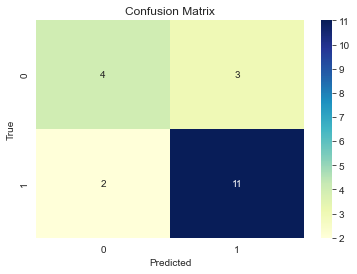

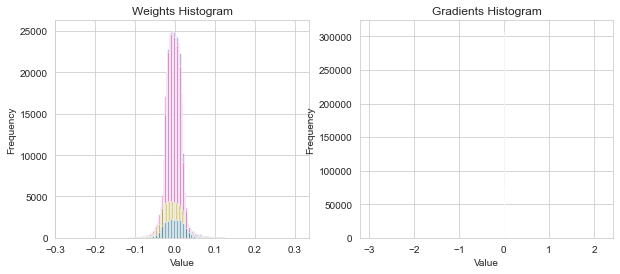

In [9]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [10]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [11]:
# Show model summary
try:
    from torchsummary import summary
    print("\nModel summary:")

    original_device = device
    if device == 'mps': # because MPS is not supported by torchsummary
        device = 'cpu'
    model.to(device)

    summary(model, input_size=(1, 40, 431), device=device)

    if original_device == 'mps': # Restore original device
        device = original_device
        model.to(device)

except ImportError:
    print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")


Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 40, 20, 216]           1,040
              ReLU-2          [-1, 40, 20, 216]               0
            Conv2d-3          [-1, 80, 10, 108]          80,080
              ReLU-4          [-1, 80, 10, 108]               0
            Conv2d-5           [-1, 160, 5, 54]         320,160
              ReLU-6           [-1, 160, 5, 54]               0
   ConvTranspose2d-7          [-1, 80, 10, 108]         320,080
              ReLU-8          [-1, 80, 10, 108]               0
   ConvTranspose2d-9          [-1, 40, 20, 216]          80,040
             ReLU-10          [-1, 40, 20, 216]               0
  ConvTranspose2d-11          [-1, 40, 40, 432]          40,040
             ReLU-12          [-1, 40, 40, 432]               0
AdaptiveAvgPool2d-13             [-1, 40, 1, 1]               0
           Linear-14   